In [1]:
# Data packages
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
from model.rnn import GRUDecoder
from model.autoencoder import SimpleAutoEncoder
from data_processing.pipeline import encoding_pipeline, get_generic_name

In [2]:
def get_device():
    # Check if CUDA is available
    if torch.cuda.is_available():
        # If CUDA is available, select the first CUDA device
        device = torch.device("cuda:0")
        print("Using CUDA device:", torch.cuda.get_device_name(0))
    # Check for MPS availability on supported macOS devices (requires PyTorch 1.12 or newer)
    elif torch.backends.mps.is_available():
        # If MPS is available, use MPS device
        device = torch.device("mps")
        print("Using MPS (Metal Performance Shaders) device")
    else:
        # Fallback to CPU if neither CUDA nor MPS is available
        device = torch.device("cpu")
        print("Using CPU")
    return device
device = get_device()

Using MPS (Metal Performance Shaders) device


# Read the data

Right now the notebook is set to work with fake data. This can be changed once the pipeline works.

The data is stored as a Dict[person_id, Sequences] where Sequences is a Dict[year, survery_wave_response]

In [3]:
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

### Select the top 10 most important questions (there's overlap, so there's only gonna be 8)

In [4]:
importance = pd.read_csv('data/feature_importance/features_importance_xgboost.csv')

# What is the effect of increasing the number of questions?

In [5]:
from model.dataset import PretrainingDataset
from model.dataset import FinetuningDataset

In [6]:
def pretrain(pt_epochs, train_dataloader, autoencoder, optimizer_pt, loss_pt, scheduler_pt):
    for epoch in range(pt_epochs):

        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
        for i, (year, seq) in loop_object :
            optimizer_pt.zero_grad()
            year = year.to(device)
            seq = seq.to(device)
            
            x = autoencoder(year, seq)
            loss = loss_pt(x.permute(0,2,1), seq.long())
                                                            
            loss.backward()
            optimizer_pt.step()
        ## After epoch end
        scheduler_pt.step()
        

def finetune(num_epochs_ft, train_dataloader, autoencoder, decoder, ft_loss, ft_optimizer, aggregator, num_cols):
    for epoch in range(num_epochs_ft):
        # print(epoch)
        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
        for i, batch in loop_object :        
            ft_optimizer.zero_grad() 
            inputs, labels = batch
            labels = labels.to(torch.float).to(device)

            input_year, input_seq = inputs
            bs, ss = labels.size(0), 14
            input_year = input_year.reshape(-1).to(device)
            input_seq = input_seq.reshape(bs * ss, -1).to(device)

            encodings = autoencoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
            encodings = aggregator(encodings) # make sure that the number of dimensions is aligned after the Simple Decoder
            mask = ~((input_seq == 101).sum(-1) == num_cols).view(bs,ss).detach()

            # Forward pass
            xx = decoder(encodings, mask)
            outputs = F.sigmoid(xx)

            loss = ft_loss(torch.flatten(outputs), labels)  

            #loss.backward(retain_graph=True)
            loss.backward()
            ft_optimizer.step()

In [7]:
def evaluate(dataloader, encoder, decoder, num_cols, aggregator):
    val_loss = []
    preds = []
    targets = []

    ## Set both models into the eval mode
    decoder.eval()
    encoder.eval()
    for batch in dataloader:
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
        encodings = aggregator(encodings) # make sure that the number of dimensions is aligned after the Simple Decoder
        mask = ~((input_seq == 101).sum(-1) == num_cols).view(bs,ss).detach()

        # Forward pass
        xx = decoder(encodings, mask)
        outputs = torch.nn.functional.sigmoid(xx).flatten()
        loss = ft_loss(outputs, labels)  
        val_loss.append(loss.detach().cpu().numpy())
        preds.extend(outputs.detach().cpu().numpy().tolist())
        targets.extend(labels.cpu().numpy().tolist())


    # Concatenate all the batches
    predictions = (torch.tensor(preds) > 0.5).float()
    probs = F.sigmoid(predictions)
    actuals = torch.tensor(targets).flatten()

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
    map_roc = average_precision_score(actuals.numpy(), probs.numpy())
    
    return precision, recall, f1, map_roc

In [76]:
PT_HIDDEN_DIM=128
PT_BATCH_SIZE=128
PT_NUM_EPOCHS=5
PT_LEARNING_RATE=10e-2

FT_BATCH_SIZE = 16
FT_ENCODING_SIZE = 64
FT_HIDDEN_SIZE = 64

FT_NUM_EPOCHS = 3
FT_LEARNING_RATE= 5e-3
n_questions = [50, 500, 1000, 2000, 4000, 8000, 16000, 27000]
reps = 3

targets = targets[targets.new_child.notna()].reset_index(drop=True)

In [77]:
prec_list = []
rec_list = []
f1_list = []
train_prec_list = []
train_rec_list = []
train_f1_list = []

n_question_list = []
n_col_list = []

train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)

for n_question in n_questions:
    print(n_question)
    custom_pairs = importance.iloc[:n_question].feature.map(lambda x: get_generic_name(x))

    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)
    pretrain_dataset = PretrainingDataset(sequences)
    
    SEQ_LEN = pretrain_dataset.get_seq_len()
    vocab_size = pretrain_dataset.get_vocab_size()

    pt_dataloader = DataLoader(pretrain_dataset, batch_size=PT_BATCH_SIZE, shuffle=True)

    for rep in range(reps):

        # initialize autoencoder and pretrain    
        autoencoder = SimpleAutoEncoder(vocab_size=vocab_size, embedding_size=PT_HIDDEN_DIM, sequence_len=SEQ_LEN).to(device)
        autoencoder.train()
        autoencoder.to(device)

        pt_loss_cls = nn.CrossEntropyLoss()
        pt_optimizer = optim.RAdam(autoencoder.parameters(), lr = PT_LEARNING_RATE, weight_decay=1e-2, decoupled_weight_decay=True)
        pt_scheduler = optim.lr_scheduler.CosineAnnealingLR(pt_optimizer, T_max = PT_NUM_EPOCHS, eta_min = 1e-5, last_epoch = -1)

        autoencoder.train()
        pretrain(pt_epochs=PT_NUM_EPOCHS,
            train_dataloader=pt_dataloader,
            autoencoder=autoencoder,
            loss_pt=pt_loss_cls,
            optimizer_pt=pt_optimizer,
            scheduler_pt=pt_scheduler,
            )
        autoencoder.eval()

        # initialize GRU and perform fine-tuning    

        rnn_data = {
            person_id: (
                torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
                torch.tensor([wave_response for _, wave_response in wave_responses.items()]).to(device)
                )
                for person_id, wave_responses in sequences.items()
        }

        train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
        test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

        train_dataset = FinetuningDataset(train_data, targets = targets)
        test_dataset = FinetuningDataset(test_data, targets = targets)

        train_dataloader = DataLoader(train_dataset, batch_size=FT_BATCH_SIZE, shuffle=True)
        test_dataloader  = DataLoader(test_dataset,  batch_size=FT_BATCH_SIZE)

        aggregator = nn.Sequential(
            nn.LazyInstanceNorm1d(),
            nn.LazyLinear(FT_ENCODING_SIZE),
            nn.LazyBatchNorm1d()).to(device)

        decoder = GRUDecoder(
            input_size=FT_ENCODING_SIZE,
            hidden_size=FT_HIDDEN_SIZE,
            max_seq_len=14,
            dropout=0.15,
            bidirectional= False, 
            num_layers=2,
            with_attention= True
        ).to(device)

        # Define loss function and optimizer for RNN
        ft_loss = torch.nn.BCELoss()
        ft_optimizer = torch.optim.RAdam(list(decoder.parameters()) + list(autoencoder.parameters()) + list(aggregator.parameters()) , 
                                                                           lr=FT_LEARNING_RATE, 
                                                                           weight_decay=1e-3, 
                                                                           decoupled_weight_decay=True)
        ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = FT_NUM_EPOCHS, eta_min = 1e-6, last_epoch = -1)

        # Training loop
        decoder.train()
        aggregator.train()
        
        NUM_COLS = next(iter(train_dataloader))[0][1].shape[-1]
        finetune(
            num_epochs_ft=FT_NUM_EPOCHS,
            train_dataloader=train_dataloader,
            autoencoder=autoencoder,
            ft_loss=ft_loss,
            ft_optimizer=ft_optimizer,
            decoder=decoder,
            aggregator=aggregator,
            num_cols=NUM_COLS
        )
        
        precision, recall, f1, map_roc = evaluate(dataloader=test_dataloader,
                                                encoder=autoencoder,
                                                decoder=decoder,
                                                num_cols=NUM_COLS,
                                                aggregator=aggregator)
        precision_train, recall_train, f1_train, map_roc_train = evaluate(dataloader=train_dataloader,
                                                                          encoder=autoencoder,
                                                                          decoder=decoder,
                                                                          num_cols=NUM_COLS,
                                                                          aggregator=aggregator
                                                                          )
        
        prec_list.append(precision)
        rec_list.append(recall)
        f1_list.append(f1)

        train_prec_list.append(precision_train)
        train_rec_list.append(recall_train)
        train_f1_list.append(f1_train)
        
        n_question_list.append(n_question)
        n_col_list.append(NUM_COLS)

50


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)
Epochs 0: 702it [00:29, 23.51it/s]
Epochs 1: 702it [00:29, 23.71it/s]
Epochs 2: 702it [00:29, 24.08it/s]
Epochs 3: 702it [00:29, 23.74it/s]
Epochs 4: 702it [00:29, 23.85it/s]
/opt/anaconda3/envs/eyra-rank/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:07,  6.85it/s]
Epochs 1: 50it [00:07,  6.89it/s]
Epochs 2: 50it [00:07,  6.90it/

100


Epochs 0: 702it [00:53, 13.08it/s]
Epochs 1: 702it [00:45, 15.35it/s]
Epochs 2: 702it [00:38, 18.01it/s]
Epochs 3: 702it [00:39, 17.99it/s]
Epochs 4: 702it [00:40, 17.34it/s]
/opt/anaconda3/envs/eyra-rank/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:10,  4.65it/s]
Epochs 1: 50it [00:10,  4.99it/s]
Epochs 2: 50it [00:09,  5.06it/s]
Epochs 3: 50it [00:10,  5.00it/s]
Epochs 4: 50it [00:09,  5.03it/s]
Epochs 5: 50it [00:10,  4.99it/s]
Epochs 6: 50it [00:10,  4.99it/s]
Epochs 7: 50it [00:09,  5.02it/s]
Epochs 8: 50it [00:10,  4.92it/s]
Epochs 9: 50it [00:10,  4.97it/s]
Epochs 0: 702it [00:52, 13.36it/s]
Epochs 1: 702it [00:48, 14.62it/s]
Epochs 2: 702it [00:45, 15.57it/s]
Epochs 3: 702it [00:45, 15.58it/s]
Epochs 4: 702it [00:46, 15.00it/s]
/opt/anaconda3

250


/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)
Epochs 0: 702it [02:40,  4.37it/s]
Epochs 1: 702it [02:07,  5.50it/s]
Epochs 2: 702it [01:41,  6.92it/s]
Epochs 3: 702it [01:31,  7.66it/s]
Epochs 4: 702it [01:39,  7.07it/s]
/opt/anaconda3/envs/eyra-rank/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Epochs 0: 50it [00:19,  2.53it/s]
Epochs 1: 50it [00:19,  2.63it/s]
Epochs 2: 50it [00:19,  2.51it/

KeyboardInterrupt: 

In [70]:
results = pd.DataFrame({
    'Precision_test': prec_list,
    'Recall_test': rec_list,
    'f1_test': f1_list,
    'Precision_train': train_prec_list,
    'Recall_train': train_rec_list,
    'f1_train': train_f1_list,
    'n_questions': n_question_list
    })
results

,Precision_test,Recall_test,f1_test,Precision_train,Recall_train,f1_train,n_questions
0,0.711111,0.64,0.673684,0.917722,0.895062,0.906250,50
1,0.681818,0.60,0.638298,0.821429,0.851852,0.836364,250
2,0.700000,0.56,0.622222,0.956790,0.956790,0.956790,500
3,0.777778,0.56,0.651163,0.935714,0.808642,0.867550,750


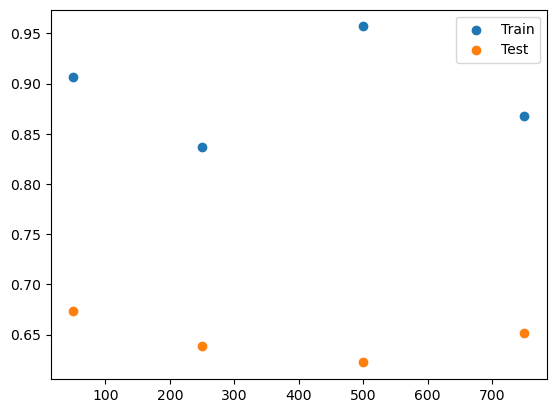

In [71]:
fig, ax = plt.subplots()
ax.scatter(results['n_questions'], results['f1_train'], color='C0', label='Train')
ax.scatter(results['n_questions'], results['f1_test'], color='C1', label='Test')
plt.legend()
plt.show()

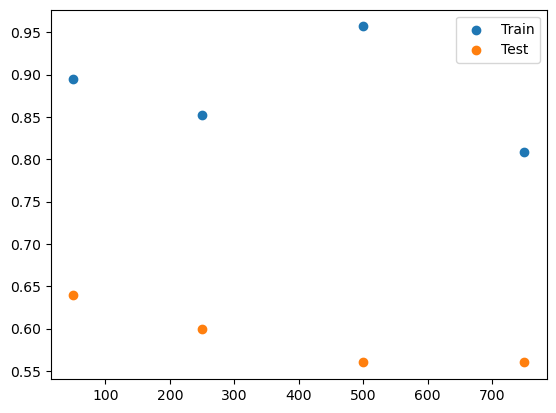

In [75]:

fig, ax = plt.subplots()
ax.scatter(results['n_questions'], results['Recall_train'], color='C0', label='Train')
ax.scatter(results['n_questions'], results['Recall_test'], color='C1', label='Test')
plt.legend()
plt.show()

In [49]:

batch = next(iter(train_dataloader))        

inputs, labels = batch

input_year, input_seq = inputs
bs, ss = labels.size(0), 14
print(input_seq.shape)
input_seq = input_seq.reshape(bs * ss, -1)

print(input_seq.shape)


torch.Size([16, 14, 385])
torch.Size([224, 385])


In [52]:
next(iter(train_dataloader))[0][1].shape[-1]


385